### Let's visualize a watershed for beaching drifters on the SW Coast of South America

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [2]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

In [42]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

Creating map...


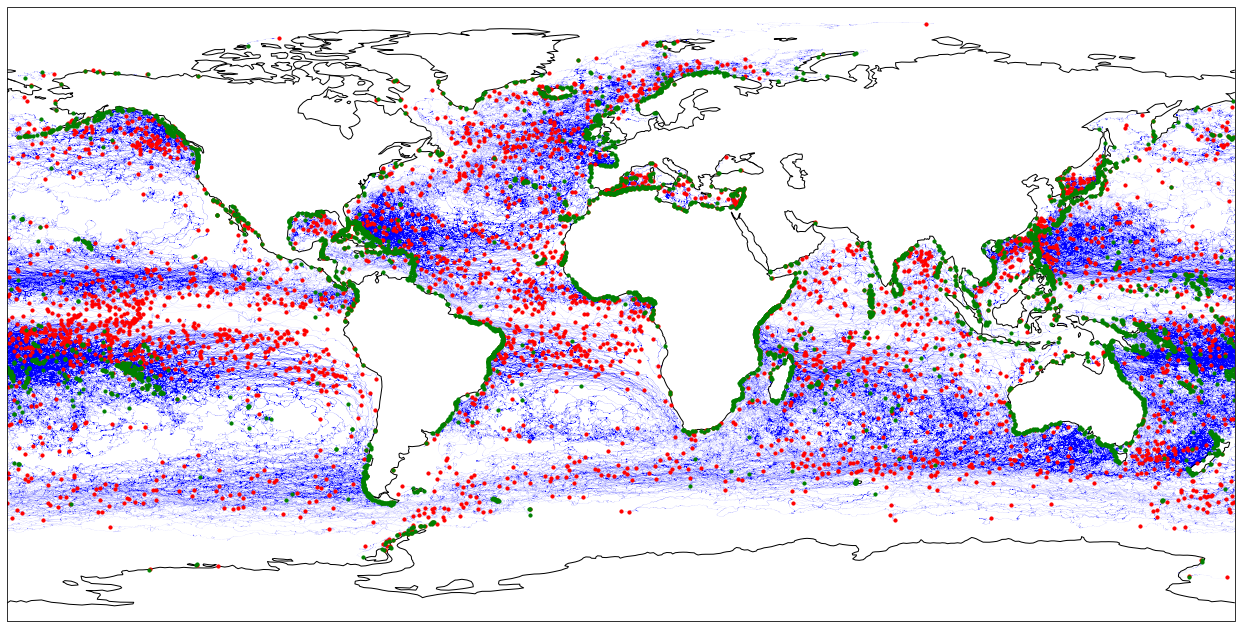

In [121]:
# let's first look at all start points (red), beaching points (green), and trajectories of beached drifters:
#create map
# 120, 150, 20, 45 jap
print("Creating map...")
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

plt.scatter(beach['lon'], beach['lat'], marker='o', color='blue', s=0.000005)

# Plot red dots for the first points
first_points = beach.drop_duplicates(subset='id', keep='first')

plt.scatter(first_points['lon'], first_points['lat'], color='red', s=10, marker='o')

# Plot green dots for the last points
last_points = beach.drop_duplicates(subset='id', keep='last')

plt.scatter(last_points['lon'], last_points['lat'], color='green', s=10, marker='o')

### Now, let's begin by looking at start points, beaching points, and trajectories that make up the 'watershed' of the SW Coast of South America

In [43]:
# Let's get all ids that beach within the specified region

# Define the latitude and longitude range of the specified region
min_lat, max_lat = -60, -30
min_lon, max_lon = -83, -68


# Initialize the set to store IDs within the region
ids_within_region = set()

# select beach points
last_points = beach.drop_duplicates(subset='id', keep='last')
ids = last_points['id']
lats = last_points['lat']
lons = last_points['lon']

# Iterate through each entry in 'beach_drogued_end_extract'
for i in range(len(ids)):
    # Check if the latitude and longitude are within the specified range
    if min_lat <= lats.iloc[i] <= max_lat and min_lon <= lons.iloc[i] <= max_lon:
        
        # Add the ID to the set 'points_within_region'
        ids_within_region.add(ids.iloc[i])

In [44]:
# let's get all time,lat,lon,ve,vn of every id that is in ids_within_region
beach_region = beach_undrogued[beach_undrogued['id'].isin(ids_within_region)]

Creating map...


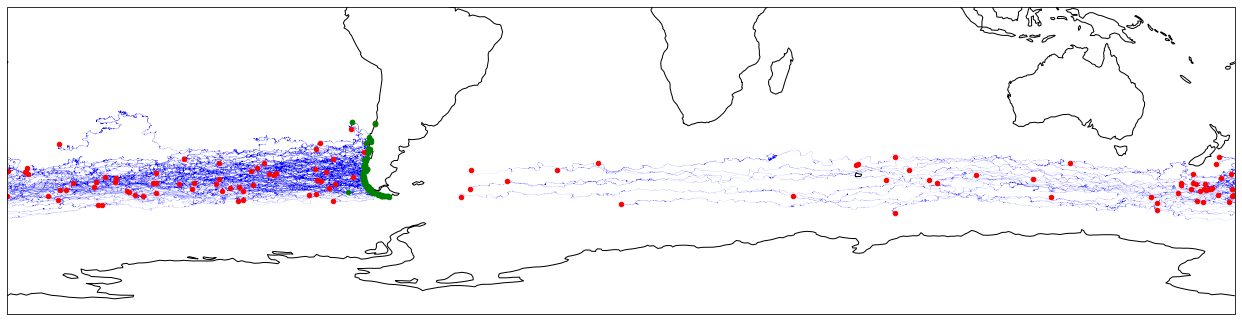

In [145]:
#create map
# 120, 150, 20, 45 jap
print("Creating map...")
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 0], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

plt.scatter(beach_region['lon'], beach_region['lat'], marker='o', color='blue', s=0.000009)


# Plot red dots for the first points
first_points = beach_region.drop_duplicates(subset='id', keep='first')

plt.scatter(first_points['lon'], first_points['lat'], color='red', s=20, marker='o')

# Plot green dots for the last points
last_points = beach_region.drop_duplicates(subset='id', keep='last')

plt.scatter(last_points['lon'], last_points['lat'], color='green', s=20, marker='o')

### Next, let's get all ids that pass through the 'watershed' but don't beach at the specified region 

In [107]:
# We start by collecting all ids that don't beach within the specified region:
beach_not_in_region = beach[~beach['id'].isin(beach_region_ids)]

In [138]:
# Now let's further reduce beach_not_in_region based on whether any id ever has a coordinate within the 'watershed'

# Define the latitude and longitude range of the 'watershed'
min_watershed_lat, max_watershed_lat = -57, -40
min_watershed_lon, max_watershed_lon = -180, 180

# Get ids of any drifter that ever is in the 'watershed' region
pass_through_watershed_ids = (beach_not_in_region[
    (beach_not_in_region['lat'].between(min_watershed_lat, max_watershed_lat)) &
    (beach_not_in_region['lon'].between(min_watershed_lon, max_watershed_lon))
])['id']

# Get full trajectory of drifters that ever go within the 'watershed' region
pass_through_watershed = beach[beach['id'].isin(pass_through_watershed_ids)]

Creating map...


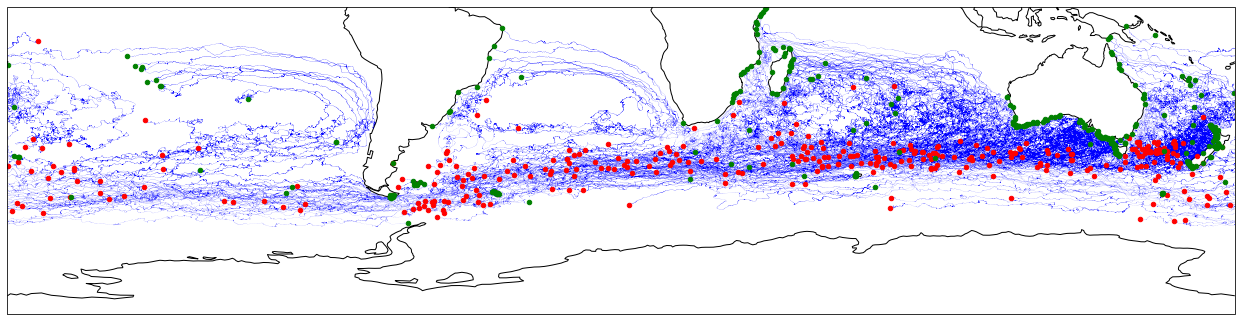

In [146]:
# let's first look at all start points (red), beaching points (green), and trajectories of beached drifters:
#create map
# 120, 150, 20, 45 jap
print("Creating map...")
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 0], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

plt.scatter(pass_through_watershed['lon'], pass_through_watershed['lat'], marker='o', color='blue', s=0.000009)

# Plot red dots for the first points
first_points = pass_through_watershed.drop_duplicates(subset='id', keep='first')

plt.scatter(first_points['lon'], first_points['lat'], color='red', s=20, marker='o')

# Plot green dots for the last points
last_points = pass_through_watershed.drop_duplicates(subset='id', keep='last')

plt.scatter(last_points['lon'], last_points['lat'], color='green', s=20, marker='o')

In [ ]:
# let's define a function for calculating the probability of beaching given the count that beached
# and the count that did not beach

def probability_of_beaching(beached_count, unbeached_count):
    probability = beached_count / (beached_count + unbeached_count)
    return probability

In [ ]:
# let's use sci_stats.binned_statistic_2d to bin by lat/lon and count

# beached
n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=beach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])

# unbeached
n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

unbeach_undrogued_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=unbeach_undrogued['id'],
    statistic = 'count', bins = [lon_bins,lat_bins])